<a href="https://colab.research.google.com/github/NataliaKor/tutorial/blob/main/tutorial-ML-for-GWPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Machine Learning for Gravitational Wave Parameter Estimation

### Stephen Green *stephen.green2@nottingham.ac.uk* and Natalia Korsakova *korsakova@apc.in2p3.fr*

---

In this tutorial we will build a simple **parameter estimation** neural network:
* **Training data:** FastGB waveforms, parametrized only by initial frequency (f0) and amplitude; noise added during training
* **Posterior model 1:** Gaussian with learnable (diagonal) covariance matrix
* **Posterior model 2:** Learned with the Normalising Flow

This should run in about a minute on a laptop (this has to be checked).

### Exercises
1. Add inclination in addition to f0 and amp
2. Extend the Gaussian distribution to include general covariance
3. Make a PP plot

## Imports

In [2]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# pytorch imports
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch import distributions

from sklearn import datasets

In [4]:
import matplotlib.pyplot as plt
import corner
import numpy as np
if torch.cuda.is_available():
   import cupy as cp
else:
   import numpy as cp
   

In [5]:
%rm -r GBGPU

rm: cannot remove 'GBGPU': No such file or directory


In [6]:
!git clone https://github.com/NataliaKor/GBGPU.git

Cloning into 'GBGPU'...
remote: Enumerating objects: 1141, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 1141 (delta 145), reused 222 (delta 100), pack-reused 826
Receiving objects: 100% (1141/1141), 12.08 MiB | 12.75 MiB/s, done.
Resolving deltas: 100% (635/635), done.


In [7]:
from GBGPU.gbgpu.gbgpu import GBGPU
from GBGPU.gbgpu.noisemodel import AnalyticNoise 

In [8]:

# Create waveform
gb = GBGPU(use_gpu=True)


## Training data

Generate a training set that (for simplicity) samples only over amplitudes and frequencies. Generate frequency-domain waveforms using FastGB. We will add noise during training.

**Exercise:** Add more parameters

In [9]:
num_samples = 10000  # size of the training set

# Choose something in the lower frequencies
#f0_min = 0.010062
#f0_max = 0.010085

f0_min = 0.010062
f0_max = 0.010084

amp_min = -23.
amp_max = -21.

# frequency
f0_ = np.random.uniform(f0_min, f0_max, num_samples)

# amplitude
amp_ = 10**np.random.uniform(amp_min, amp_max, num_samples)

# Normalise
amp = amp_/10**amp_max
#f0 = (f0_ - f0_min)/(f0_max - f0_min)
f0 = f0_



In [ ]:
# Choose the source at lower frequencies to make it simpler

#num_samples = 10000  # size of the training set

# Choose something in the lower frequencies
#f0_min = 0.00031
#f0_max = 0.00035

#amp_min = -23.
#amp_max = -22.

# frequency
#f0_ = np.random.uniform(f0_min, f0_max, num_samples)

# amplitude
#amp_ = 10**np.random.uniform(amp_min, amp_max, num_samples)

# Normalise
#amp = amp_/10**amp_max

#f0 = f0_



In [10]:
# Fixed parameters

fdot = 1.79e-15
lam  = 4.36
beta = 2.18
iota = 0.67
phi0 = 5.48
psi  = 0.43


#fdot = 1.856e-20
#lam  = 3.192019
#beta = 0.795375
#iota = 0.593412
#phi0 = 6.114984
#psi  = 5.678256


In [11]:
# Waveform settings

Tobs = 31536000.0
dt = 15.0
df = 1./Tobs

print('fvec_min = ', f0_min - df*64)
print('fvec_max = ', f0_max + df*64)

#fvec_min = 0.010053
#fvec_max = 0.010094

fvec_min = 0.010059
fvec_max = 0.0100861


#fvec_min = 0.000307
#fvec_max = 0.0003521

# Put the waveform in the common frequency band 
k_min = np.round(fvec_min/df).astype(int)
k_max = np.round(fvec_max/df).astype(int)
num = k_max - k_min
print('num = ', num)
freqs = (np.arange(num) + k_min)*df


fvec_min =  0.010059970573313039
fvec_max =  0.01008602942668696
num =  854


In [12]:
# Noise PSD

noise = AnalyticNoise(freqs)
psdA, psdE = noise.psd(option="A"), noise.psd(option="E")

asdA = np.sqrt(psdA)
asdE = np.sqrt(psdE)

In [14]:
# Generate training waveforms
N_points = 128
#N_points = 64

A_list = []
E_list = []

#if torch.cuda.is_available():
#    gb_cpu = gb.get()
#else:
#    gb_cpu = gb

# !!!!!!!!! 
# Has to make agnostic to gpu/cpu
for i in range(num_samples):
 
    params = np.array([amp_[i], f0_[i], fdot, 0.0, -phi0, iota, psi, lam, beta])
    gb.run_wave(*params, N = N_points, dt = dt, T = Tobs, oversample = 1)#oversample=2)
    
    i_start = (gb.start_inds.get() - k_min).astype(np.int32)
    i_end = (gb.start_inds.get() - k_min + gb.N).astype(np.int32)

    A_out = cp.zeros((1, num), dtype=cp.complex128)
    E_out = cp.zeros((1, num), dtype=cp.complex128)

    # Put waveforms in the same frequency range
    A_out[0, i_start[0] : i_end[0]] = gb.A
    E_out[0, i_start[0] : i_end[0]] = gb.E

    # Whiten waveforms and rescale so that white noise has unit variance
    A_white = A_out * cp.sqrt(4.0 * df)* dt/cp.array(asdA)
    E_white = E_out * cp.sqrt(4.0 * df)* dt/cp.array(asdE)

    A_list.append(A_white)
    E_list.append(E_white)

Awf = cp.array(A_list)
Ewf = cp.array(E_list)


In [15]:
print(cp.amax(Awf.real))

3717.1131909890196


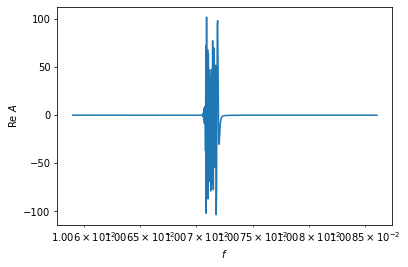

In [17]:
# Sample waveform
if torch.cuda.is_available():
  Awf_plot = Awf[0][0].real.get()
else:
  Awf_plot = Awf[0][0].real

#plt.plot(freqs, (Awf[0][0].real)**2 + (Awf[0][0].imag)**2 )
plt.plot(freqs, Awf_plot)
plt.xscale('log')
plt.xlabel('$f$')
plt.ylabel('Re $A$')
#plt.xlim((10, f_final))
plt.show()

### Package into a pytorch Dataset

In [18]:
# Combine parameters into array

par_norm = np.stack((1.0, 10**amp_max)).astype(np.float32)
parameters = np.stack((f0, amp), axis=1).astype(np.float32)

In [19]:
# For best training, parameters should be standardized (zero mean, unit variance across the training set)

parameters_mean = np.mean(parameters, axis=0)
parameters_std = np.std(parameters, axis=0)

parameters_standardized = (parameters - parameters_mean) / parameters_std

In [20]:
# Waveforms
#
# Repackage real and imaginary parts
#


#norm_for_all = cp.amax(cp.c_[Awf.real, Awf.imag, Ewf.real, Ewf.imag])
norm_for_all = cp.amax(cp.c_[Awf.real, Awf.imag])
waveforms = cp.c_[Awf.real.squeeze(), Awf.imag.squeeze()].astype(cp.float32)
#                  Ewf.real.squeeze(), Ewf.imag.squeeze()].astype(cp.float32)



In [21]:
class WaveformDataset(Dataset):
    
    def __init__(self, parameters, waveforms, norm_for_all):
        self.parameters = parameters
        self.waveforms = waveforms

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]
        
        # Add unit normal noise to the signal
        noise = cp.random.normal(size = signal.shape).astype(cp.float32)
        data = ((signal + noise)/norm_for_all).astype(cp.float32)
        
        return torch.tensor(data), torch.tensor(params)

In [22]:
waveform_dataset = WaveformDataset(parameters_standardized, waveforms, norm_for_all)

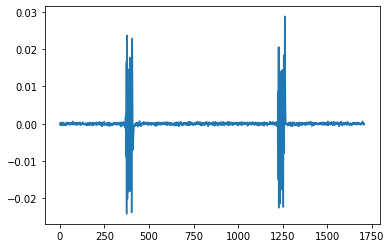

In [23]:
# We can sample from the WaveformDataset. This gives us pairs of data and parameters, different noise realizations each time.

x, y = waveform_dataset[0]
plt.plot(x)

## Posterior Model

In [24]:
# Neural networks are constructed by subclassing nn.Module
#
# This has to implement an __init__() and forward() method

class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        
        # Hidden layers
        hidden_net_list = []
        hidden_net_list.append(
            nn.Linear(input_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.hidden_net_list = nn.ModuleList(hidden_net_list)
        
        # Output layers
        self.output_mean = nn.Linear(hidden_dims[-1], output_dim)
        self.output_log_sigma = nn.Linear(hidden_dims[-1], output_dim)
        
        # Activation function
        self.activation = activation
        
    def forward(self, x):
        """Pass x through all the layers of the network and return the Gaussian distribution"""
        
        h = x
        for layer in self.hidden_net_list:
            h = self.activation(layer(h))

        # Output layer defines a Gaussian
        mean = self.output_mean(h)
        log_sigma = self.output_log_sigma(h)
        sigma = torch.exp(log_sigma)
        
        # Create the Gaussian distribution
        dist = torch.distributions.MultivariateNormal(loc=mean, scale_tril=torch.diag_embed(sigma))
        
        return dist

In [25]:
input_dim = waveforms.shape[-1]
output_dim = parameters.shape[-1]
hidden_dims = [512, 256, 128, 64, 32]

model = NeuralNetwork(input_dim, hidden_dims, output_dim)

In [26]:
print(model)

NeuralNetwork(
  (hidden_net_list): ModuleList(
    (0): Linear(in_features=1708, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_mean): Linear(in_features=32, out_features=2, bias=True)
  (output_log_sigma): Linear(in_features=32, out_features=2, bias=True)
  (activation): ReLU()
)


## Training

In [27]:
# Split the dataset into training and test sets

train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:
# The DataLoaders iterate over samples, returning torch tensors containing a batch of data

train_features, train_labels = next(iter(train_dataloader))

In [29]:
train_features

tensor([[-5.4903e-04,  6.1927e-06,  1.6194e-04,  ...,  4.4844e-05,
         -5.3879e-06,  3.9644e-05],
        [ 1.5218e-04,  1.3243e-04,  1.8312e-04,  ..., -1.7015e-04,
         -1.9792e-04, -9.8732e-06],
        [-4.4345e-05, -1.4527e-04, -1.1693e-04,  ...,  8.8986e-05,
         -1.5796e-04, -7.1300e-05],
        ...,
        [ 2.0547e-05, -2.6163e-04,  1.1898e-04,  ..., -1.9020e-04,
         -2.1216e-04, -1.9694e-05],
        [ 5.1987e-04, -1.7465e-05,  9.3847e-05,  ..., -4.1667e-04,
         -3.2354e-04,  7.6563e-05],
        [ 2.1877e-04,  2.3784e-05,  2.3818e-04,  ..., -1.0103e-04,
         -2.4543e-04,  1.6664e-04]])

In [30]:
train_features.shape

torch.Size([64, 1708])

In [31]:
# We use the Adam optimizer.

optimizer = torch.optim.Adam(model.parameters())

In [32]:
# Training and test loops

def train_loop(dataloader, model, optimizer):
 
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss
        dist = model(X)        
        loss = - dist.log_prob(y)
        
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss
            
        
        
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            dist = model(X)
            loss = - dist.log_prob(y)
            test_loss += loss.sum()

    test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [33]:
epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 2.919849  [    0/ 8000 samples]
Loss: 2.061748  [ 3200/ 8000 samples]
Loss: 1.472474  [ 6400/ 8000 samples]
Average loss: 2.0466
Test loss: 1.632589 

Epoch 2
-------------------------------
Loss: 1.709322  [    0/ 8000 samples]
Loss: 1.134530  [ 3200/ 8000 samples]
Loss: 0.912518  [ 6400/ 8000 samples]
Average loss: 1.1929
Test loss: 1.208977 

Epoch 3
-------------------------------
Loss: 1.430781  [    0/ 8000 samples]
Loss: 0.494434  [ 3200/ 8000 samples]
Loss: 0.728341  [ 6400/ 8000 samples]
Average loss: 0.8132
Test loss: 0.487214 

Epoch 4
-------------------------------
Loss: 0.312620  [    0/ 8000 samples]
Loss: 0.369857  [ 3200/ 8000 samples]
Loss: 0.391158  [ 6400/ 8000 samples]
Average loss: 0.4040
Test loss: 0.613207 

Epoch 5
-------------------------------
Loss: 0.198356  [    0/ 8000 samples]
Loss: -0.032702  [ 3200/ 8000 samples]
Loss: 0.289479  [ 6400/ 8000 samples]
Average loss: 0.1882
Test loss: 0.098043 

Epoch 6
------

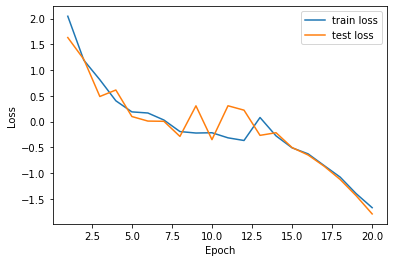

In [34]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Evaluation

### Posterior plots

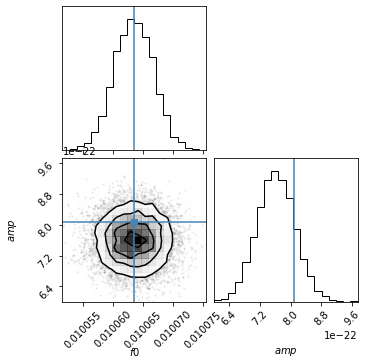

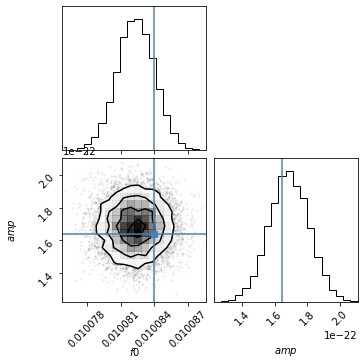

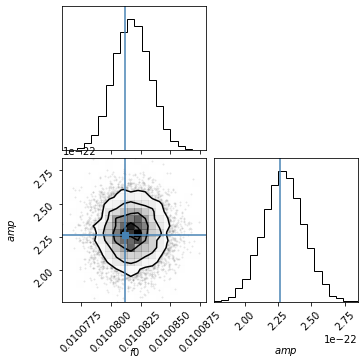

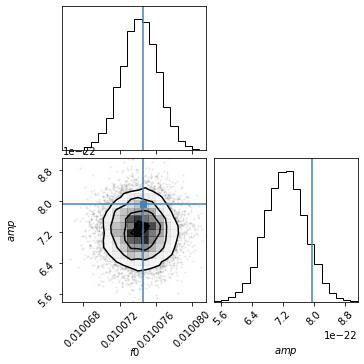

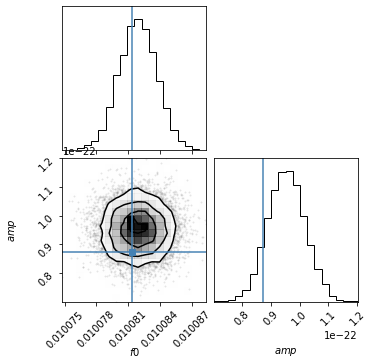

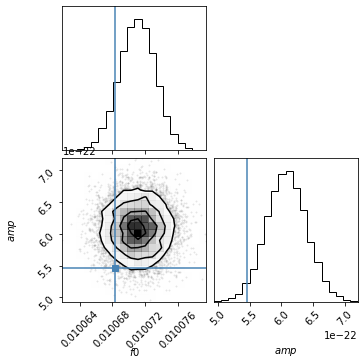

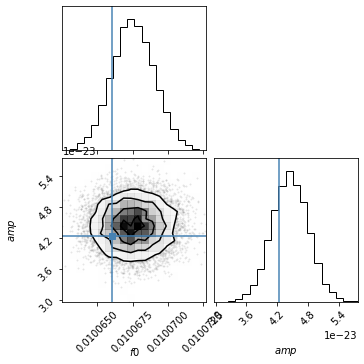

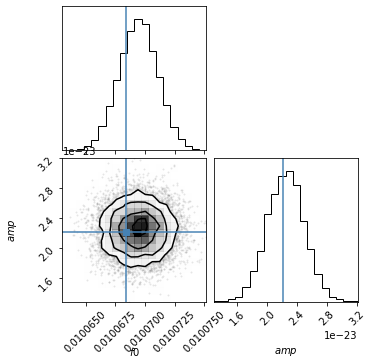

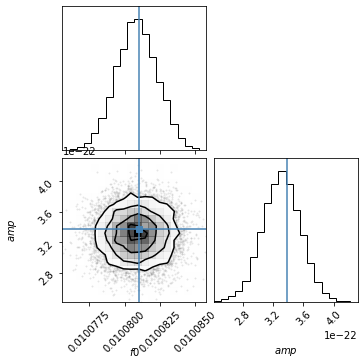

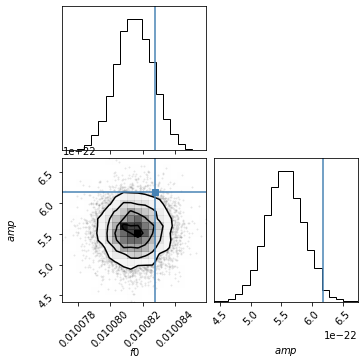

In [35]:
num_posteriors = 10
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Predict a posterior
    dist = model(test_x)

    # Sample the posterior
    pred_samples = dist.sample((10000,)).numpy()

    # Undo the standardization
    
    pred_samples = parameters_std * pred_samples + parameters_mean
    pred_samples = pred_samples*par_norm.T
    truth = parameters_std * test_y.numpy() + parameters_mean
    truth = truth*par_norm.T

    # Plot
    corner.corner(pred_samples, truths=truth, labels=['$f0$', '$amp$'])
    plt.show()


# @Normalising flow 

We will implement the RealNVP 

https://arxiv.org/abs/1605.08803

It is based on the simple affine transformation, where part of the dimensions are scaled and shifted.

Let's assume that we separate the dimensions into two parts:
$x_{1:d}$ and $x_{d+1:D}$  

Half of the dimensions are kept unchanged:

$y_{1:d} = x_{1:d}$

Other half is transformed with affine transform. Lets define $t$ is a 'shift' function and $s$ is a 'scale' functions. We will parameterise them with neural networks. We apply this transformations to the first part of data:
$s(x_{1:d})$ and $t(x_{1:d})$.

-----------------------------------------------------------------------------


To devide dimensions we use a mask:

In [36]:
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
masks

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])

Trabsformations $s$ and $t$ :

In [37]:
# Define functions s and t as simple fully connected networks:

s_func = lambda: nn.Sequential(nn.Linear(2, 256), 
                             nn.ReLU(), 
                             nn.Linear(256, 256), 
                             nn.ReLU(), 
                             nn.Linear(256, 2), 
                             nn.Tanh())

t_func = lambda: nn.Sequential(nn.Linear(2, 256), 
                              nn.ReLU(), 
                              nn.Linear(256, 256), 
                              nn.ReLU(), 
                              nn.Linear(256, 2))



Then we combine it with the data from the second half of dimensions and get:
$y_{d+1:D} = x_{d+1:D} \odot \exp(s(x_{1:d})) + t(x_{1:d})$.



Base distribution is chosen to be Gaussian Multivariate Distribution.

In [48]:
# Define base distribution from which we are going to sample 
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [ ]:
print(prior.sample(sample_shape=1))

TypeError: ignored

Implement the forward pass of the flow:

1 step: dimensions of the data have to be separate to two parts.   
Separation is performed by applying the mask to the data.


In [ ]:
class RealNVP(nn.Module):
    def __init__(self, s_func, t_func, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.register_buffer('mask', mask)

        #self.mask = nn.Parameter(mask, requires_grad=False)

        self.t = torch.nn.ModuleList([t_func() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([s_func() for _ in range(len(masks))])
        
    def g(self, x):
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        

Implement the inverse pass of the flow:

In [ ]:
flow = RealNVP(s_func, t_func, masks, prior)

Choose optimiser.  
Define loss function.  
Choose dataset to demonstrate the performance.

In [38]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(2001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

NameError: ignored

Plot the results.

AttributeError: ignored

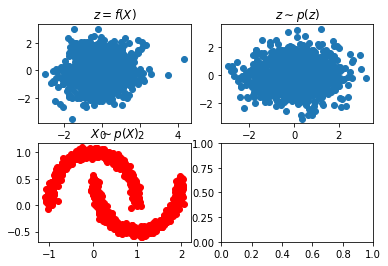

In [ ]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

Rewrite the flow conditioning it on the data.

In [49]:
class RealNVP_wf(nn.Module):
    def __init__(self, s_func, t_func, mask, prior):
        super(RealNVP_wf, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        #self.register_buffer('mask', mask)
        self.t = torch.nn.ModuleList([t_func() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([s_func() for _ in range(len(masks))])
        
    def g(self, z, w):
        print('Inside g')
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            x_wf = torch.cat([x_, w],dim=1)
            s = self.s[i](x_wf)*(1 - self.mask[i])
            t = self.t[i](x_wf)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x, w):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            z_wf = torch.cat([z_, w],dim=1)
            s = self.s[i](z_wf) * (1-self.mask[i])
            t = self.t[i](z_wf) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    
    def log_prob(self, x, w):
        z, logp = self.f(x, w)
        return self.prior.log_prob(z) + logp
        


In [50]:
s_func = lambda: nn.Sequential(nn.Linear(1710, 2048), nn.ReLU(),  # nn.BatchNorm1d(2048)
                               nn.Linear(2048, 512), nn.ReLU(), 
                               nn.Linear(512, 256), nn.ReLU(),
                               nn.Linear(256, 2), nn.Tanh())
t_func = lambda: nn.Sequential(nn.Linear(1710, 2048), nn.ReLU(), 
                               nn.Linear(2048, 512), nn.ReLU(), 
                               nn.Linear(512, 256), nn.ReLU(),
                               nn.Linear(256, 2))


In [53]:
flow_wf = RealNVP_wf(s_func, t_func, masks, prior)

In [54]:
optimizer = torch.optim.Adam([p for p in flow_wf.parameters() if p.requires_grad==True], lr=1e-4)
losses = []  
losses_val = []
# EPOCHS 
for t in range(21): 
    
    flow_wf.train()
    # ITERATIONS (go once through the dataset)
    for batch, (X, y) in enumerate(train_dataloader):
    #for i, (waveform, mu, q, chi1, chi2) in enumerate(loader_mbhb):
        #x_wf = waveform[:,7900:-4060].float()
        #x_mu = mu.float()
        #x_q = q.float()
        #x_chi1 = chi1.float()
        #x_chi2 = chi2.float()

        #x = torch.cat([x_mu.view(-1,1), x_q.view(-1,1), x_chi1.view(-1,1), x_chi2.view(-1,1)],dim=1)

        loss = -flow_wf.log_prob(y, X).mean()
        

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

    if t % 1 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        losses.append(loss)

        flow_wf.eval()
        for batch, (X, y) in enumerate(test_dataloader):
        #for i, (waveform, mu, q, chi1, chi2) in enumerate(loader_mbhb_test):

              #x = torch.cat([x_mu.view(-1,1), x_q.view(-1,1), x_chi1.view(-1,1), x_chi2.view(-1,1)],dim=1)

              loss_val = -flow_wf.log_prob(y, X).mean()
              

        print('iter %s:' % t, 'loss_val = %.3f' % loss_val)
        losses_val.append(loss_val)

# Save model after training



iter 0: loss = 0.069
iter 0: loss_val = -0.497
iter 1: loss = -1.207
iter 1: loss_val = -1.517
iter 2: loss = -1.769
iter 2: loss_val = -1.961
iter 3: loss = -1.838
iter 3: loss_val = -2.307
iter 4: loss = -2.385
iter 4: loss_val = -2.314
iter 5: loss = -2.666
iter 5: loss_val = -2.573
iter 6: loss = -2.658
iter 6: loss_val = -2.187
iter 7: loss = -2.414
iter 7: loss_val = -2.998
iter 8: loss = -2.995
iter 8: loss_val = -3.340
iter 9: loss = -3.098
iter 9: loss_val = -2.859
iter 10: loss = -3.152
iter 10: loss_val = -2.520
iter 11: loss = -3.372
iter 11: loss_val = -3.212
iter 12: loss = -3.349
iter 12: loss_val = -2.936
iter 13: loss = -2.990
iter 13: loss_val = -3.148
iter 14: loss = -3.197
iter 14: loss_val = -3.115
iter 15: loss = -2.808
iter 15: loss_val = -2.782
iter 16: loss = -3.491
iter 16: loss_val = -3.021
iter 17: loss = -3.104
iter 17: loss_val = -3.214
iter 18: loss = -3.531
iter 18: loss_val = -3.099
iter 19: loss = -3.499
iter 19: loss_val = -3.440
iter 20: loss = -3.36

[tensor(0.0692, grad_fn=<NegBackward0>), tensor(-1.2065, grad_fn=<NegBackward0>), tensor(-1.7688, grad_fn=<NegBackward0>), tensor(-1.8380, grad_fn=<NegBackward0>), tensor(-2.3845, grad_fn=<NegBackward0>), tensor(-2.6661, grad_fn=<NegBackward0>), tensor(-2.6581, grad_fn=<NegBackward0>), tensor(-2.4144, grad_fn=<NegBackward0>), tensor(-2.9950, grad_fn=<NegBackward0>), tensor(-3.0983, grad_fn=<NegBackward0>), tensor(-3.1516, grad_fn=<NegBackward0>), tensor(-3.3723, grad_fn=<NegBackward0>), tensor(-3.3491, grad_fn=<NegBackward0>), tensor(-2.9902, grad_fn=<NegBackward0>), tensor(-3.1970, grad_fn=<NegBackward0>), tensor(-2.8085, grad_fn=<NegBackward0>), tensor(-3.4910, grad_fn=<NegBackward0>), tensor(-3.1041, grad_fn=<NegBackward0>), tensor(-3.5310, grad_fn=<NegBackward0>), tensor(-3.4989, grad_fn=<NegBackward0>), tensor(-3.3647, grad_fn=<NegBackward0>)]


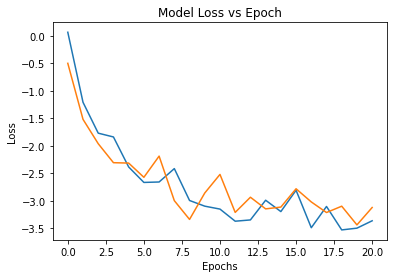

In [55]:
# Plot loss
print(losses)

plt.figure()
plt.plot(torch.FloatTensor(losses).detach().numpy())
plt.plot(torch.FloatTensor(losses_val).detach().numpy())
plt.title("Model Loss vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

wf.shape =  torch.Size([10000, 1708])
z.shape =  torch.Size([10000, 2])
Inside g


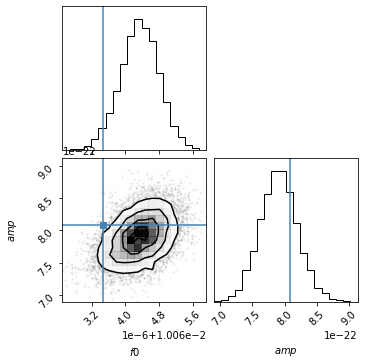

wf.shape =  torch.Size([10000, 1708])
z.shape =  torch.Size([10000, 2])
Inside g


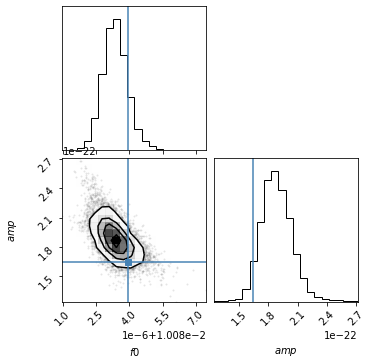

wf.shape =  torch.Size([10000, 1708])
z.shape =  torch.Size([10000, 2])
Inside g


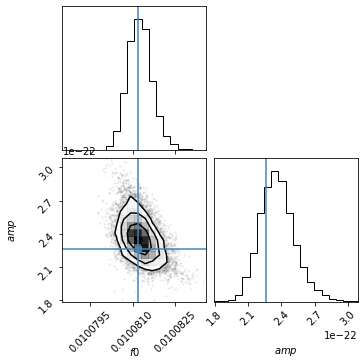

wf.shape =  torch.Size([10000, 1708])
z.shape =  torch.Size([10000, 2])
Inside g


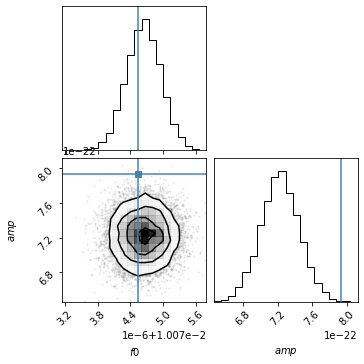

wf.shape =  torch.Size([10000, 1708])
z.shape =  torch.Size([10000, 2])
Inside g


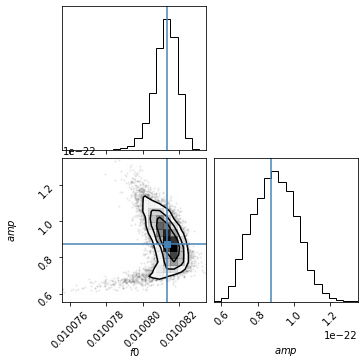

In [56]:
num_posteriors = 5
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    #for i in range(0, 100):
    #    samples_temp = flow.sample(num_samples, coeff_norm).squeeze().cpu().detach().numpy()
    #    samples = np.vstack([samples, samples_temp])

    wf = torch.from_numpy(np.tile(test_x, (num_samples, 1))).type(torch.FloatTensor)
    # Predict a posterior
    print('wf.shape = ', wf.shape)
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    z = torch.from_numpy(np.random.multivariate_normal(mean, cov, size=num_samples)).type(torch.FloatTensor)
    #z = prior.sample((num_samples))
    print('z.shape = ', z.shape)
    pred_samples = flow_wf.g(z, wf).detach().numpy() 
    #dist = model(test_x)

    # Sample the posterior
    #pred_samples = dist.sample((10000,)).numpy()

    # Undo the standardization
    
    pred_samples = parameters_std * pred_samples + parameters_mean
    pred_samples = pred_samples*par_norm.T
    truth = parameters_std * test_y.numpy() + parameters_mean
    truth = truth*par_norm.T

    # Plot
    corner.corner(pred_samples, truths=truth, labels=['$f0$', '$amp$'])
    plt.show()